# Accomodate data to classes

## Dataset structure classes

| Class name    | Purpose                              |
| ------------- |:-------------------------------------|
| Player        | Session data  for a player           |
| Game          | Collection of games in this session  |
| Goal          | A given game level being played      |
| Trial         | An attempt to play the current level |
| Move          | A single move taken in this trial    |


## Dataset classes source code

In [1]:
%%writefile datastructure.py
class Sample:
    """Todos os jogadores de uma amostra"""
    def __init__(self, sample, **kwargs):
        self.players = [Player(**player)  for player in sample]
        
    def visit(self, visitor):
        visitor.visit_sample(self, players=self.players)


class Player:
    """Todos os dados de um jogador, que joga uma coleção de Games"""
    def __init__(self, session, games, **kwargs):
        self.session = session
        self.games = [Game(**game)  for game in games]
        
    def visit(self, visitor):
        visitor.visit_player(self, session=self.session, games=self.games)

    
class Game:
    """Todos os games jogados por um jogador onde cada é jogado em várias fases ou Goals"""
    def __init__(self, name, time, maxlevel, goal, **kwargs):
        self.name, self.time, self.maxlevel = name, time, maxlevel
        self.goals = [Goal(**a_goal) for a_goal in goal]
        
    def visit(self, visitor):
        visitor.visit_game(self, goal=self.goals, name=self.name, time=self.time, maxlevel=self.maxlevel)

        
class Goal:
    """Uma fase de um jogo jogada em várias tentativas ou Trials"""
    def __init__(self, time, level, markers, houses, headings, trial, **kwargs):
        self.time, self.level, self.markers, self.houses, self.headings = time, level, markers, houses, headings
        self.trials = [Trial(a_trial) for a_trial in trial]
        
    def visit(self, visitor):
        visitor.visit_goal(self, trial=self.trials , time=self.time, level=self.level, 
                           markers=self.markers, houses=self.houses, headings=self.headings)
        

class Trial:
    """Uma tentativa de jogar uma fase onde são feitas diversas jogadas ou Moves"""
    def __init__(self, trial, **kwargs):
        self.moves = [Move(**moves) for moves in trial]
        
    def visit(self, visitor):
        visitor.visit_trial(self, moves=self.moves)

        
class Move:
    """Cada uma das jogadas executadas para completar uma tentativa"""
    def __init__(self, xpos, house, ypos, player, state, score, result, time, marker,
                 delta=0, categoria=0, cor=0, acertos=0, outros=0, forma=0, numero=0,
                 carta_resposta=0, itpl_delta=0, shape=""):
        self.xpos, self.house, self.ypos, self.player, self.state, self.score, self.result, self.time, self.marker = \
            xpos, house, ypos, player, state, score, result, time, marker
        self.categoria, self.delta, self.itpl_delta, self.shape = categoria, delta, itpl_delta, shape
        self.cor, self.acertos, self.outros, self.forma, self.numero, self.carta_resposta = \
            cor, acertos, outros, forma, numero, carta_resposta
        # print("      Trial", xpos, house, ypos, player, state, score, result, time, delta)

    def pack_params(self):
        return dict(
            xpos=self.xpos, house=self.house, ypos=self.ypos, player=self.player, state=self.state, score=self.score,
            result=self.result, time=self.time, marker=self.marker, delta=self.delta, categoria=self.categoria,
            cor=self.cor, acertos=self.acertos, outros=self.outros, forma=self.forma,
            numero=self.numero, carta_resposta=self.carta_resposta, shape=self.shape)
        
    def visit(self, visitor):
        kwargs = self.pack_params()
        visitor.visit_move(self, **kwargs)

        
class _Move:
    def __init__(self, xpos, house, ypos, player, state, score, result, time, marker, **kwargs):
        self.xpos, self.house, self.ypos, self.player, self.state = xpos, house, ypos, player, state
        self.score, self.result, self.time, self.marker = score, result, time, marker
        
    def visit(self, visitor):
        kwargs = dict(xpos=self.xpos, house=self.house, ypos=self.ypos, player=self.player, state=self.state,
                      score=self.score, result=self.result, time=self.time, marker=self.marker)
        visitor.visit_move(self, **kwargs)


Writing datastructure.py


## Using the structure

In the example, retrieve game name used by the current player

In [3]:
from activreader import Activ
from datastructure import Player
api_stream = Activ().one_player()
player = Player(**api_stream)
_ = [print(game.name) for game in player.games]

tol
wisconsin


## Visitor class

Provides callbacks for each structural class in the dataset. Control recursion by returning __False__ when next level incursion is not necessarie.

In [8]:
%%writefile datavisitor.py
class Visitor:
    def __init__(self, leaf_action={}):
        self.action_digest = {leaf: lambda *_, **__: True for leaf in "sample player game goal trial move".split()}
        self.action_digest.update(leaf_action)
        self.current = None
        # print("Visitor", self.action_digest)
        
    def visit_sample(self, sample, players=(), **kwargs):
        # print("visit_sample", sample, players[:2])
        return [element.visit(self) for element in players]\
            if self.action_digest["sample"](sample, players=players) else []
        pass
        
    def visit_player(self, player, games=(), **kwargs):
        # print("visit_player", games[:2])
        return [element.visit(self) for element in games]\
            if self.action_digest["player"](player, games=games, **kwargs) else []
        pass
    
    # def visit_game(self, game, name=None, time=None, maxlevel=None, goal=(), **kwargs):
    def visit_game(self, game, goal=(), **kwargs):
        return [element.visit(self) for element in goal]\
            if self.action_digest["game"](game, goal=goal, **kwargs) else []

    
    def visit_goal(self, goal, time=None, level=None, markers=None, houses=None, headings=None,
                   trial=(), **kwargs):
        vkwargs=dict(time=time, level=level, markers=markers, houses=houses, headings=headings,trial=trial)
        vkwargs.update(**kwargs)
        return [element.visit(self) for element in trial]\
            if self.action_digest["goal"](goal, **vkwargs) else []
    
    def visit_trial(self, trial,  moves=(), **kwargs):
        return [element.visit(self) for element in moves]\
        if self.action_digest["trial"](trial, moves=moves, **kwargs) else []

    
    def visit_move(self, move, xpos=0, house=None, ypos=0, player=None, state=None, score=0,
                   result=None, time=None, marker=None, delta=0, categoria=0, cor=0, acertos=0,
                   outros=0, forma=0, numero=0, carta_resposta=0, itpl_delta=0, **kwargs):
        kwargs = move.pack_params()
        self.action_digest["move"](move, **kwargs)

    

Overwriting datavisitor.py


## Fixture to handle stats collection

In [10]:
from activreader import Activ
from matplotlib import pyplot as plt
from datastructure import Sample
from datavisitor import Visitor


class Rio20Stats:
    def __init__(self, date="2018", start_count=(0,100), pic_file="sample.dat"):
        self.games = {}
        self.activ_reader = activ_reader = Activ()
        self.sample_stream = activ_reader.get_jogadores(date=date, start_count=start_count)
        self.sample = None
        try:
            with open(pic_file, "rb") as pkf:
                import pickle
                self.sample = pickle.load(pkf)
        except IOError as _:
            self.sample = Sample(sample=[activ_reader.one_player(player) for player in self.sample_stream])
        self.visitor = Visitor(leaf_action=dict(game=self.count_game_play, sample=self.count_sample_play))
        
    def file_pickle_sample(self, name="sample.dat"):
        print("sample:", self.sample.players[0].session)
        import csv
        import pickle
        with open(name, 'wb') as pickle_file:
            pickle.dump(self.sample, pickle_file)
                               
    def plot_stats(self, x, xticks, y):
        # print("plot_stats", x, xticks, y, self.games)
        plt.xticks(x, xticks)
        plt.ylabel("number of participants")
        _ = plt.bar(x, y)
        
    def main(self):
        self.sample.visit(self.visitor)
        self.plot_stats(range(len(self.games)), *zip(*self.games.items()))
        return self

    def count_sample_play(self, sample, players, **kwargs):
        # print("count_game_play", sample, players[:2])
        return True

    def count_game_play(self, game, goal, name, **kwargs):
        # print("count_game_play", game, goal, name)
        self.games.update({name: self.games.setdefault(name, 0)+1})
        return False


## Storing Rio+20 sample to pickle

During Rio+20 event in Rio de Janeiro 1600 students 

In [11]:
rio = Rio20Stats(date="2012", start_count=(0,1610))
rio = rio.file_pickle_sample()


sample: {'sexo2': '', 'idade1': 17, 'idade2': None, 'ano1': 9, 'ano2': None, 'escola': 'ufrj', 'sexo1': 'M', 'starttime': '2012-05-31 12:47:13.201761', 'tipoescola': 'publica', 'endtime': ''}


## Loading Rio+20 picled data

Loads faster than fetching the data from the **ActivUFRJ** database


In [4]:
rio = Rio20Stats(pic_file="sample.dat")


## Plot game count distribution

Players can select from six different games described in the followin table.

| Label   | game description                             |
|:-------:|----------------------------------------------|
| trilha  | construct a trail connecting three houses    |
| tol     | Tower of London, move beads between sticks   |
|wisconsin| Card test to detect acceptance of new rules  |
| trainz  | manouver a train so to arrange the car order |
| cancel  | fin similar shapes given a one or two shapes |

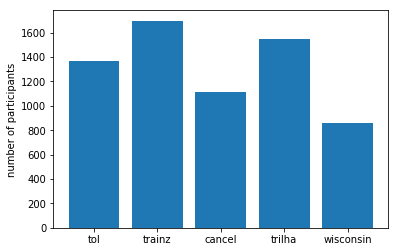

In [11]:
rio = Rio20Stats()
rio = rio.main()
# print("Rio20Stats", rio.games)
